# Setup

In [1]:
import pandas as pd
import numpy as np

In [2]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(suppress=True)

# Define functions

In [3]:
def closed_range(start, stop, step=1):
    if step - round(step) == 0:
        aux_delta = 1 if step > 0 else -1
        return [*range(start, stop + aux_delta, step)]
    else:
        aux_delta = step/100
        step_decimal_places = len(str(step).split(".")[1])
        return np.round(np.arange(start, stop + aux_delta, step), step_decimal_places).tolist()

# Read data

In [4]:
data = pd.read_csv("../data/prepared/prepared_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72739 entries, 0 to 72738
Data columns (total 43 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_response_rate                            65965 non-null  float64
 1   host_acceptance_rate                          66597 non-null  float64
 2   latitude                                      72739 non-null  float64
 3   longitude                                     72739 non-null  float64
 4   accommodates                                  72739 non-null  int64  
 5   bathrooms                                     72718 non-null  float64
 6   bedrooms                                      72567 non-null  float64
 7   beds                                          72515 non-null  float64
 8   price                                         72739 non-null  float64
 9   minimum_nights                                72739 non-null 

# Train models

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline

X_all, y_all = data.loc[:,[col for col in data.columns if col != 'price']], data['price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Apply missing imputation and target encoding
nm_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
ct_features = X_train.select_dtypes(include=['object']).columns.tolist()
features_to_target_encode = ['property_type']

nm_missing_value_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
ct_missing_value_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='none')

target_encoder = TargetEncoder(target_type='continuous')

column_transformer_missing_imputation = ColumnTransformer(
    transformers=[
        ('nm_missing_value_imputer',
         nm_missing_value_imputer,
         nm_features),
        ('ct_missing_value_imputer',
         ct_missing_value_imputer,
         [feature for feature in ct_features if feature not in features_to_target_encode]),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False)

column_transformer_target_encoding = ColumnTransformer(
    transformers=[
        ('target_encoder',
         target_encoder,
         slice(-1, None)),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False)

pipeline = Pipeline(
    steps=[
        ('column_transformer_missing_imputation', column_transformer_missing_imputation),
        ('column_transformer_stage_2', column_transformer_target_encoding)
    ]
)

X_train_t = pipeline.fit_transform(X_train, y_train) 
X_train_t = pd.DataFrame(X_train_t,columns=pipeline.get_feature_names_out())

# Use dict vectorizer to apply one hot encoding
dict_vectorizer = DictVectorizer(sparse=False)

X_train_tt = dict_vectorizer.fit_transform(X_train_t.to_dict(orient='records'))

In [6]:
X_train_tt_df = pd.DataFrame(X_train_tt, columns=dict_vectorizer.feature_names_)
X_train_tt_df.describe().T

,count,mean,std,min,25%,50%,75%,max
accommodates,58191.0000,4.5684,3.1724,1.0000,2.0000,4.0000,6.0000,16.0000
availability_30,58191.0000,15.3610,11.1585,0.0000,4.0000,15.0000,27.0000,30.0000
availability_365,58191.0000,222.3509,113.5160,0.0000,123.0000,244.0000,334.0000,365.0000
availability_60,58191.0000,35.1850,20.5807,0.0000,18.0000,37.0000,56.0000,60.0000
availability_90,58191.0000,58.1757,28.7617,0.0000,38.0000,64.0000,85.0000,90.0000
bathrooms,58191.0000,1.6330,1.1145,0.0000,1.0000,1.0000,2.0000,50.0000
bedrooms,58191.0000,1.8594,1.3816,0.0000,1.0000,1.0000,3.0000,50.0000
beds,58191.0000,2.4361,2.1774,0.0000,1.0000,2.0000,3.0000,132.0000
calculated_host_listings_count,58191.0000,20.3199,67.6528,1.0000,1.0000,3.0000,12.0000,569.0000
calculated_host_listings_count_entire_homes,58191.0000,18.3735,67.4724,0.0000,1.0000,2.0000,9.0000,569.0000


In [7]:
# Check a row
dict(zip(dict_vectorizer.feature_names_, X_train_tt[146]))

{'accommodates': 4.0,
 'availability_30': 29.0,
 'availability_365': 108.0,
 'availability_60': 59.0,
 'availability_90': 87.0,
 'bathrooms': 1.0,
 'bedrooms': 1.0,
 'beds': 2.0,
 'calculated_host_listings_count': 10.0,
 'calculated_host_listings_count_entire_homes': 0.0,
 'calculated_host_listings_count_private_rooms': 10.0,
 'calculated_host_listings_count_shared_rooms': 0.0,
 'city=austin': 0.0,
 'city=chicago': 0.0,
 'city=dallas': 0.0,
 'city=los angeles': 1.0,
 'city=san diego': 0.0,
 'has_availability_flag': 1.0,
 'host_acceptance_rate': 92.0,
 'host_email_verified_flag': 0.0,
 'host_has_profile_pic_flag': 1.0,
 'host_identity_verified_flag': 1.0,
 'host_is_superhost_flag': 1.0,
 'host_phone_verified_flag': 1.0,
 'host_response_rate': 100.0,
 'host_response_time=a few days or more': 0.0,
 'host_response_time=none': 0.0,
 'host_response_time=within a day': 0.0,
 'host_response_time=within a few hours': 0.0,
 'host_response_time=within an hour': 1.0,
 'host_work_email_verified_fla

## Linear regression

In [8]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression().fit(X_train_tt, np.log10(y_train))


In [9]:
dict(zip(dict_vectorizer.feature_names_, lr_model.coef_))

{'accommodates': 0.02780587452333155,
 'availability_30': 0.0038153440735135503,
 'availability_365': -4.403852073732147e-06,
 'availability_60': -0.00010618581213488361,
 'availability_90': -0.00028317777104539324,
 'bathrooms': 0.06711576682642498,
 'bedrooms': 0.03477971550107846,
 'beds': -0.006283812862287453,
 'calculated_host_listings_count': 0.0034277937953016042,
 'calculated_host_listings_count_entire_homes': -0.003110405103508372,
 'calculated_host_listings_count_private_rooms': -0.006241041570441544,
 'calculated_host_listings_count_shared_rooms': -0.007597264479651783,
 'city=austin': 0.12500931476612018,
 'city=chicago': 3.4251290728003854,
 'city=dallas': 0.7926563734026457,
 'city=los angeles': -2.3614913038927696,
 'city=san diego': -1.9813034570763712,
 'has_availability_flag': 0.04517075843993965,
 'host_acceptance_rate': 0.0001364301018274977,
 'host_email_verified_flag': 0.003905265986242648,
 'host_has_profile_pic_flag': 0.012882245233400105,
 'host_identity_verif

In [10]:
lr_model.intercept_

-35.36172560135617

## Elastic net regression

In [11]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

en_model = ElasticNet(alpha=1, tol=1)
en_param_distributions = dict(l1_ratio=closed_range(0,1,0.1))

en_random_search = GridSearchCV(
    estimator=en_model,
    param_grid=en_param_distributions,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=4)

en_model_hyper = en_random_search.fit(X_train_tt, np.log10(y_train))

In [12]:
en_model_hyper.best_params_

{'l1_ratio': 0.0}

## Random forest

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf_model = RandomForestRegressor(n_estimators=50)
rf_param_distributions = dict(
    max_depth=closed_range(10,30,5),
    min_samples_split=closed_range(2,10),
    min_samples_leaf=closed_range(1,5)
    )

rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_distributions,
    scoring='neg_mean_squared_error',
    n_iter=5,
    cv=5,
    n_jobs=4,
    random_state=123)

rf_model_hyper = rf_random_search.fit(X_train_tt, np.log10(y_train))

In [14]:
rf_model_hyper.best_params_

{'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 30}

# Evaluate models

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

X_test_t = pipeline.transform(X_test)
X_test_t = pd.DataFrame(X_test_t, columns=pipeline.get_feature_names_out())

X_test_tt = dict_vectorizer.transform(X_test_t.to_dict(orient='records'))

In [16]:
mean_squared_error_results = {
    'Linear regression': 
    mean_squared_error(np.log10(y_test), lr_model.predict(X_test_tt)),
    'Elastic net regression': 
    mean_squared_error(np.log10(y_test), en_model_hyper.predict(X_test_tt)),
    'Random forest': 
    mean_squared_error(np.log10(y_test), rf_model_hyper.predict(X_test_tt))
} 

mean_squared_error_results

{'Linear regression': 0.04851953612441947,
 'Elastic net regression': 0.06126266912618255,
 'Random forest': 0.027225801109705853}

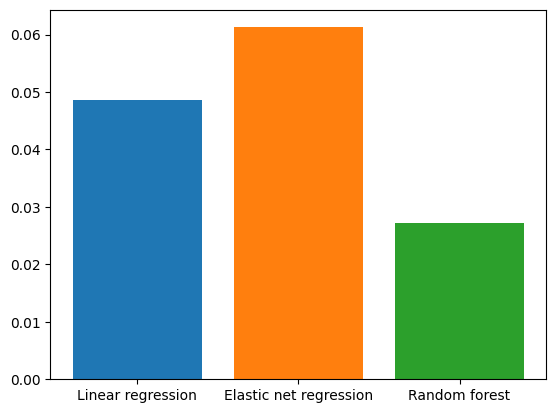

In [17]:
plt.bar(list(mean_squared_error_results.keys()),
        list(mean_squared_error_results.values()),
        color=['tab:blue','tab:orange','tab:green'])
plt.show()